In [7]:
import numpy as np
import pandas as pd
%matplotlib inline
# for plotting
import seaborn as sns
sns.set(style='white', font_scale=1.5)
#for working with Bam files
import pysam
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
import math

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import fcluster

from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

In [8]:
cd /broad/mushroom_lasagna/YB/Ht115_new_samples/

/broad/mushroom_lasagna/YB/Ht115_new_samples


In [9]:
full_mut = pd.read_pickle('HT115_full_mutations.pkl') #the pkl file from step one
#full_mut = pd.read_pickle('RPE1_full_mutations.pkl') #the pkl file from step one
print full_mut.shape

(64770, 7)


In [11]:
# Convert a number from int into list
def vec_from_int_to_list(vec,size):
    vec = map(int, str(vec))
    nvec=[0]*(size-len(vec))
    nvec=nvec+vec
    return nvec


# This function return 0 if one of the subsample have low coverage (smaller than the input threshold)
def chk_len(a,thr):
    flag=1
    for j in a:
        if sum(j[2])<thr:
            flag=0
    return flag

#print to screen - all subclone for specific variant
def present(mut,ind):
    for i in mut.loc[ind].full_data :
        print i[0],i[2]
    return

#choose r out of n
def nCr(n,r):
    f = math.factorial
    return f(n) / f(r) / f(n-r)

#This function convert nucleotide from int to char (return -1 if different)
def convert_ind(ini):#'ATCG'
    if ini==0:
        ans="A"
    elif ini==1:
        ans="T"
    elif ini==2:
        ans="C"
    elif ini==3:
        ans="G"
    else:
        ans=-1
    return ans

In [12]:
#####This function calculates the coincidence quality score of every variant.
# The function calculate the probability of each sample to be belong to its consensus-assigned group
#(‘reference’ or ‘alternative’) considering the base content in the read alignment at the locus in question for each sample. 

def Clean_cluster (fdata,vec):
    ind=0
    x1=[]
    x2=[]
    x3=[]
    x4=[]
    #For every subclone
    for line in fdata:
        points=line[2]+1 #the precentage data
        #print points
        points=points.astype(float)/sum(points)
        #print points
        x1.append(points[0])
        x2.append(points[1])
        x3.append(points[2])
        x4.append(points[3])
    #use the 'vector' to sort the samples into groups of ‘reference’ or ‘alternative’.
    # calculate center of the group  
    cg1x1=np.sum(np.array(x1)*np.array(vec))/(np.sum(np.array(vec)))
    cg1x2=np.sum(np.array(x2)*np.array(vec))/(np.sum(np.array(vec)))
    cg1x3=np.sum(np.array(x3)*np.array(vec))/(np.sum(np.array(vec)))
    cg1x4=np.sum(np.array(x4)*np.array(vec))/(np.sum(np.array(vec)))
    
    vec2=1-np.array(vec)
    
    cg2x1=np.sum(np.array(x1)*np.array(vec2))/(np.sum(np.array(vec2)))
    cg2x2=np.sum(np.array(x2)*np.array(vec2))/(np.sum(np.array(vec2)))
    cg2x3=np.sum(np.array(x3)*np.array(vec2))/(np.sum(np.array(vec2)))
    cg2x4=np.sum(np.array(x4)*np.array(vec2))/(np.sum(np.array(vec2)))
    
    #print "cg1",cg1x1,",",cg1x2,",",cg1x3,",",cg1x4,"  cg2:",cg2x1,",",cg2x2,",",cg2x3,",",cg2x4
    cg1=[cg1x1,cg1x2,cg1x3,cg1x4]
    cg2=[cg2x1,cg2x2,cg2x3,cg2x4]
    ccg=np.array(cg2)-np.array(cg1)
    #print "ccg: ",ccg
    ref_all=np.where(ccg==ccg.max())[0][0]
    alt_all=np.where(ccg==ccg.min())[0][0]
    #print "ref:",ref_all," alt:", alt_all

    
    altAF=[]
    refAF=[]
    index=0
    #Calculate the reference and alternative allele 
    ##  (for HT115 dataset drop the outer sample (HTW37) from this calculation)
    for line in fdata:
        tt= line[2]
        if (index!=1):#if not 37
            if vec[index]==1:#if it belong to the mutated
                altAF.append(float(tt[alt_all])/sum(tt))
                #print "line: ",tt," = alt ",float(tt[alt_all])/sum(tt)
            else:
                refAF.append(float(tt[ref_all])/sum(tt))
                #print "line: ",tt," = ref ",float(tt[ref_all])/sum(tt)
        index+=1
    #print "mean altAF:",np.mean(altAF)
    #print "mean refAF:",np.mean(refAF)
    
    alt_af=np.mean(altAF)
    ref_af=np.mean(refAF)
    
    # now for each subclone calculates the chance to be belong to both groups    
    samp=0
    chance=[]
    for line in fdata:
        points=line[2]+1
        
        p1=1
        p2=1
        count=alt_all            
        p1=p1*((nCr(sum(points),points[count])) * (cg1[count]**points[count]) *((1-cg1[count])**(sum(points)-points[count])))
        p2=p2*((nCr(sum(points),points[count])) * (cg2[count]**points[count]) *((1-cg2[count])**(sum(points)-points[count])))
        
        count=ref_all
        p1=p1*((nCr(sum(points),points[count])) * (cg1[count]**points[count]) *((1-cg1[count])**(sum(points)-points[count])))
        p2=p2*((nCr(sum(points),points[count])) * (cg2[count]**points[count]) *((1-cg2[count])**(sum(points)-points[count])))

        #print "p1: ",p1
        #print "p2: ",p2
        
        if vec[samp]==1:
            tch=p1/(p1+p2)
        else:
            tch=p2/(p1+p2)
        if np.isnan(tch):
            tch=np.nan_to_num(tch)
        chance.append(tch)
            
        #print line[0],": p1 =",p1," p2=",p2
        #print line[0],": ratio: ",chance[samp]
        samp=samp+1
    #print "Min chance: ",min(chance)
    return chance,ref_af,alt_af,ref_all,alt_all
 

In [ ]:
# For RPE1 branches + leaf variants: 
# the known possible subclone coincidents taken from the imaging dataset:

#v1=11000000000     #24+27
#v2=1100000000001   #22+23+44
#v3=110010000       #34+37+38
#v4=10010000        #37+38
#v5=1110            #36+32+28
#v6=1111000000001   #44+27+24+23+22
#v7=110             #28+32
#v8=111110000       #34+37+39+46+38
#v9=1100000         #39+46
#v10=1100000000000  #22+23


#vectors=[v1,v2,v3,v4,v5,v6,v7,v8,v9,v10]
#for i in range(13):
#    v=1*10**i
#    vectors.append(v)
##print vectors

In [13]:
# For HT115 branches + leaf variants: 
# the known possible subclone coincidents taken from the imaging dataset:

v1=1001000000     #47+54
v2=10110010       #49+34+63+44
v3=10100001101    #45+48+56+38+57
v4=10010000       #49+63
v5=100010         #44+34
v6=10100000100    #38+48+45
v7=1001           #57+56
v8=10100000000    #48+45
v9=101001000000   #54+47+37

vectors=[v1,v2,v3,v4,v5,v6,v7,v8,v9]
for i in range(12):
    v=1*10**i
    vectors.append(v)
#print vectors

In [ ]:
# “Known lineage structure -> called variants” approach:
# calculate coincident and its quality score for every suggested variant.

cmut=full_mut
ssize= len(full_mut.full_data[10])

count=0
events=0
nmut=[] # the new database
columns=('contig','position','context','ref_all','alt_all','t_lod_fstar','full_data','vector','ref_af','alt_af','Min_prob')
thr=5 #length threshold (if one of the samples reading depth is less than this threshold, we will not use this variant.
drop=0
for ind in cmut.index:
    #print ind
    a=cmut.full_data[ind]
    if chk_len(a,thr)==1:
        ch_arr=[]
        rf_arr=[]
        al_arr=[]
        refaf_arr=[]
        altaf_arr=[]
        for vec in vectors:
            nvec=vec_from_int_to_list(vec,ssize)
            fdata=cmut.full_data[ind]
            chance,ref_af,alt_af,ref,alt = np.array(Clean_cluster(fdata,nvec))
            ch_arr.append(min(chance))
            refaf_arr.append(ref_af)
            altaf_arr.append(alt_af)
            rf_arr.append(ref)
            al_arr.append(alt)
    
    
        #print "index: ",ind
        ch_arr=np.array(ch_arr)
        best_ind=np.where(ch_arr==max(ch_arr))[0][0]
        best_vec=vectors[best_ind]
        nref_af=refaf_arr[best_ind]
        nalt_af=altaf_arr[best_ind]
        nref=rf_arr[best_ind]
        nalt=al_arr[best_ind]

        line=(cmut.contig[ind],cmut.position[ind],cmut.context[ind],convert_ind(nref),convert_ind(nalt),cmut.t_lod_fstar[ind],cmut.full_data[ind],best_vec,nref_af,nalt_af,max(ch_arr))
        nmut.append(line)
    
        if (count%500==0):
              print "did ",count
  
        #if (count>10):
        #     break
        count=count+1
    else:
        drop=drop+1 
print "We drop ",drop," samples due to size"
nmut = pd.DataFrame(nmut, columns=columns)

#add this cleaning of inf values
for ind in nmut.index:
    if np.isinf(nmut.Min_prob[ind]):
        nmut.set_value(index=ind,col='Min_prob',value=0)

nmut.to_pickle('/broad/mushroom_lasagna/YB/Ht115_new_samples/active_search_09_sub.pkl') 
print "finito"

In [ ]:
### For RPE1 only: 
#Classifying SNVs in the first cell division of the lineage by using the reference genome:

##upload the reference mutation - 
#ref="/seq/references/Homo_sapiens_assembly19/v1/Homo_sapiens_assembly19.fasta"
#fastafile = pysam.Fastafile(ref)
#T=0
#F=0
#for ind in keep.index:
#    pos=keep.position[ind]
#    chromo=keep.contig[ind]
#    input_seq=fastafile.fetch(chromo, pos-1, pos)
#    if (keep.alt_af[ind]>keep.ref_af[ind]):
#        ref=keep.alt_all[ind]
#    else:
#        ref=keep.ref_all[ind]
#        
#    if (input_seq== ref):
#        T+=1
#    else:
#        F+=1
#print "right=",T," wrong=",F 

In [ ]:
### Fro RPE1 switch by AF:
#keep=nmut
#sw=0
#for ind in keep.index:
#    if (keep.vector[ind]==111110000): 
#        if (keep.alt_af[ind]>cmut.ref_af[ind]): #if true switch vector:
#            keep.set_value(ind,'vector',1111000001111)
#            temp=keep.ref_all[ind]
#            keep.set_value(ind,'ref_all',keep.alt_all[ind])
#            keep.set_value(ind,'alt_all',temp)
#            temp=keep.ref_af[ind]
#            keep.set_value(ind,'ref_af',keep.alt_af[ind])
#            keep.set_value(ind,'alt_af',temp)
#            sw+=1
#print "switched ",sw
#nmut=keep

## For HT115 only:
## Classifying SNVs in the first cell division of the lineage using the outer sample.
### Convert branch coincident from v9=101001000000 #54+47+37 into: 10110111111

In [16]:
keep=nmut
sw=0
for ind in keep.index:
    if (keep.vector[ind]==101001000000): 
        keep.set_value(ind,'vector',10110111111)
        temp=keep.ref_all[ind]
        keep.set_value(ind,'ref_all',keep.alt_all[ind])
        keep.set_value(ind,'alt_all',temp)
        temp=keep.ref_af[ind]
        keep.set_value(ind,'ref_af',keep.alt_af[ind])
        keep.set_value(ind,'alt_af',temp)
        sw+=1
print "switched ",sw
nmut=keep

/broad/blainey_lab/blainey-ipython/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:5: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  """
/broad/blainey_lab/blainey-ipython/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:7: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  import sys
/broad/blainey_lab/blainey-ipython/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:8: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
/broad/blainey_lab/blainey-ipython/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:10: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # Remove the CWD from sys.path while we load stuff.
/broad/blainey_lab/blainey-ipython/

switched  1903


# seperate candidate list into branch and leaf variants:

In [17]:
keep=nmut

klist_tree=[]
klist_leaf=[]
ssize= len(keep.full_data[10])

for ind in keep.index: #convert vec from int to 
    vec=int(keep.vector[ind])
    nvec=vec_from_int_to_list(vec,ssize)
    if sum(nvec)>1: #drop single mutations
        klist_tree.append(ind)
    if sum(nvec)==1:
        klist_leaf.append(ind)
        
tree = keep.ix[klist_tree]
leaf = keep.ix[klist_leaf]
tree=tree.reset_index()
leaf=leaf.reset_index()
tree=tree.drop_duplicates(['position','contig'])
leaf=leaf.drop_duplicates(['position','contig'])
#keep=keep.drop_duplicates(['position'])
print "just tree:",tree.shape
print "just leafs:",leaf.shape

just tree: (18533, 12)
just leafs: (46095, 12)


/broad/blainey_lab/blainey-ipython/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  from ipykernel import kernelapp as app
/broad/blainey_lab/blainey-ipython/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  app.launch_new_instance()


In [18]:
print "just tree before: ",tree.shape
ttree=tree[tree.Min_prob>0.99]
print "after thr: ",ttree.shape
ttree=ttree[(ttree.ref_af>0.85) | (ttree.alt_af<0.85)]
print "after AF : ",ttree.shape
th=ttree[(ttree.alt_af>0.9)]
print "homo-homo mutations",th.shape

just tree before:  (18533, 12)
after thr:  (3027, 12)
after AF :  (2779, 12)
homo-homo mutations (145, 12)


In [19]:
print "just leafs before: ",leaf.shape
tleaf=leaf[leaf.Min_prob>0.99]
print "after thr: ",tleaf.shape
tleaf=tleaf[(tleaf.ref_af>0.85) | (tleaf.alt_af<0.85)]
print "after AF : ",tleaf.shape
lh=tleaf[(tleaf.alt_af>0.9)]
print "homo-homo mutations",lh.shape

just leafs before:  (46095, 12)
after thr:  (10101, 12)
after AF :  (9883, 12)
homo-homo mutations (194, 12)


# Generating data for figure 2:

1001000000     810
10110010       404
10100001101    319
10010000       317
100010         297
10100000100    171
1001           167
10100000000    151
10110111111    143
Name: vector, dtype: int64


/broad/blainey_lab/blainey-ipython/packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


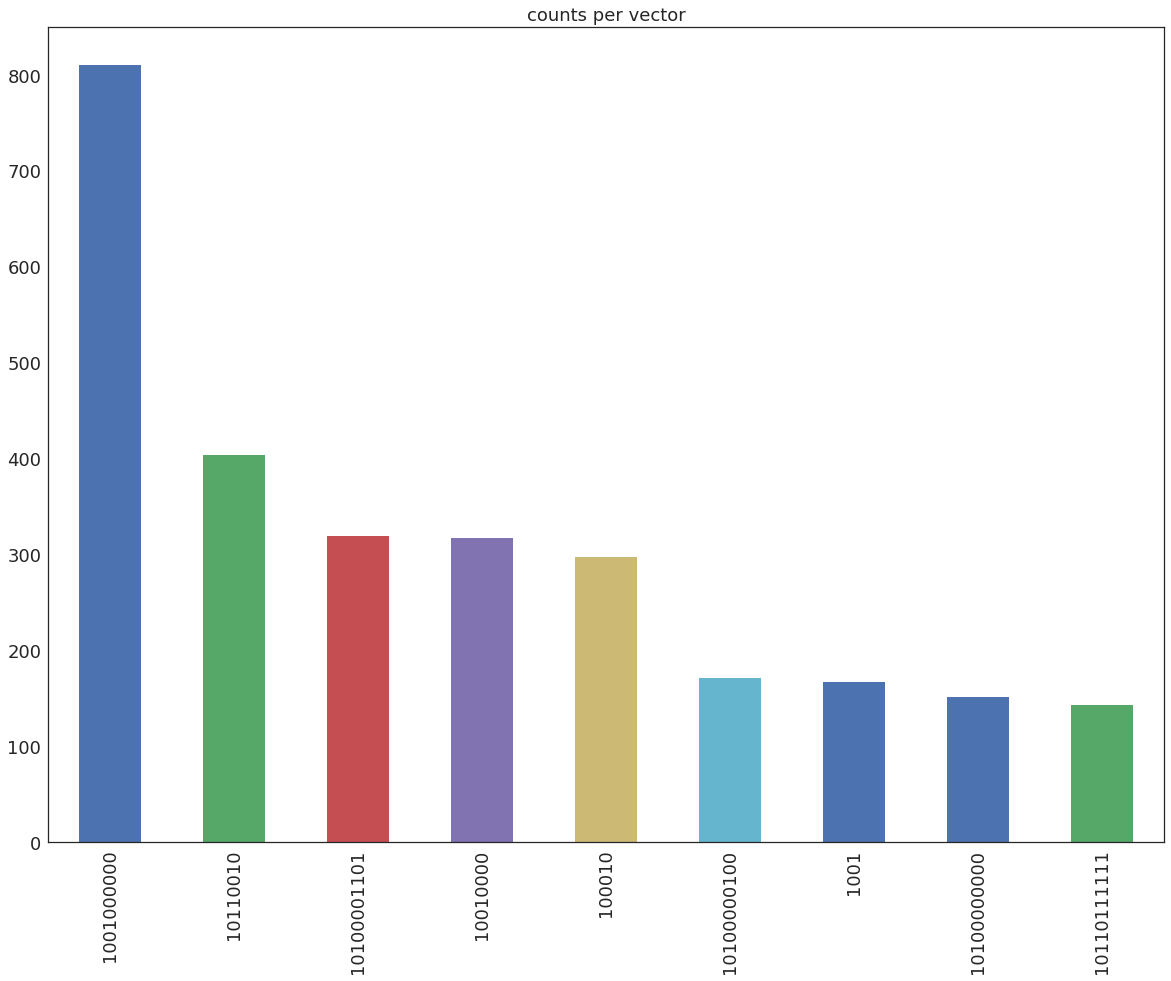

In [20]:
keep2=ttree
nmut2=keep2.vector.value_counts().reset_index(name="count").query("count >0")["index"]
nmut2=keep2[keep2.vector.isin(nmut2)]
nmut2=nmut2.vector.value_counts()

ax=nmut2.plot(kind="bar", title="counts per vector",figsize=(20, 15),fontsize=18)
print nmut2

10000000        1208
1000            1142
1               1034
10              1017
10000            945
100000           902
1000000000       798
100000000        795
10000000000      731
1000000          698
100              610
100000000000       3
Name: vector, dtype: int64


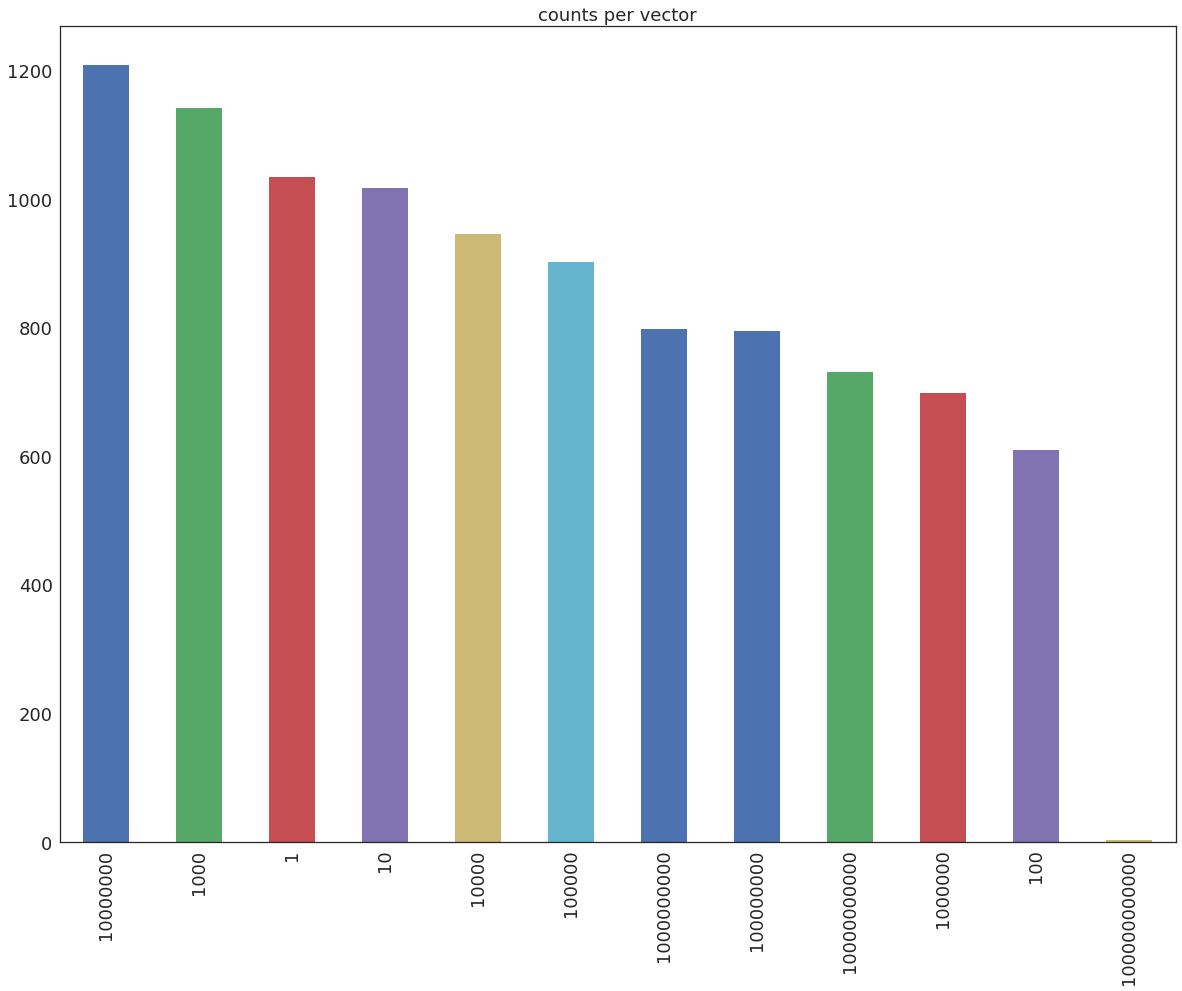

In [21]:
keep2=tleaf
nmut2=keep2.vector.value_counts().reset_index(name="count").query("count >0")["index"]
nmut2=keep2[keep2.vector.isin(nmut2)]
nmut2=nmut2.vector.value_counts()

ax=nmut2.plot(kind="bar", title="counts per vector",figsize=(20, 15),fontsize=18)
print nmut2

(0, 0.996)

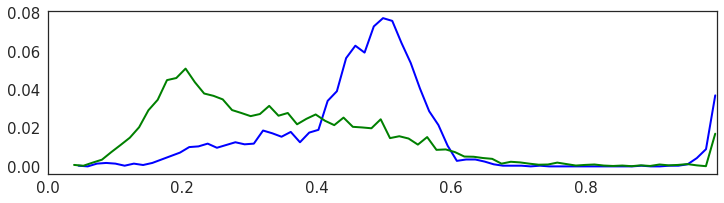

In [22]:
bin_size=70
plt.figure(figsize=(12,3))
ax1=plt.subplot(111)
hist,bins=np.histogram(ttree.alt_af,bins=bin_size)
xs=(bins[:-1] + bins[1:])/2
hist=(hist)/float(sum(hist))
plt.plot(xs, hist, linewidth=2,color= 'b')

hist,bins=np.histogram(tleaf.alt_af.dropna(),bins=bin_size)
xs=(bins[:-1] + bins[1:])/2
hist=(hist)/float(sum(hist))
plt.plot(xs, hist, linewidth=2,color= 'g')

ax1.set_xlim([0,0.996])


### for Figure S13 -> Homozygote mutation rate:

for Homozygote tree 
1001000000     45
10110010       19
10100001101    17
100010         13
10100000000    13
10010000       11
10110111111    11
1001            9
10100000100     7
Name: vector, dtype: int64


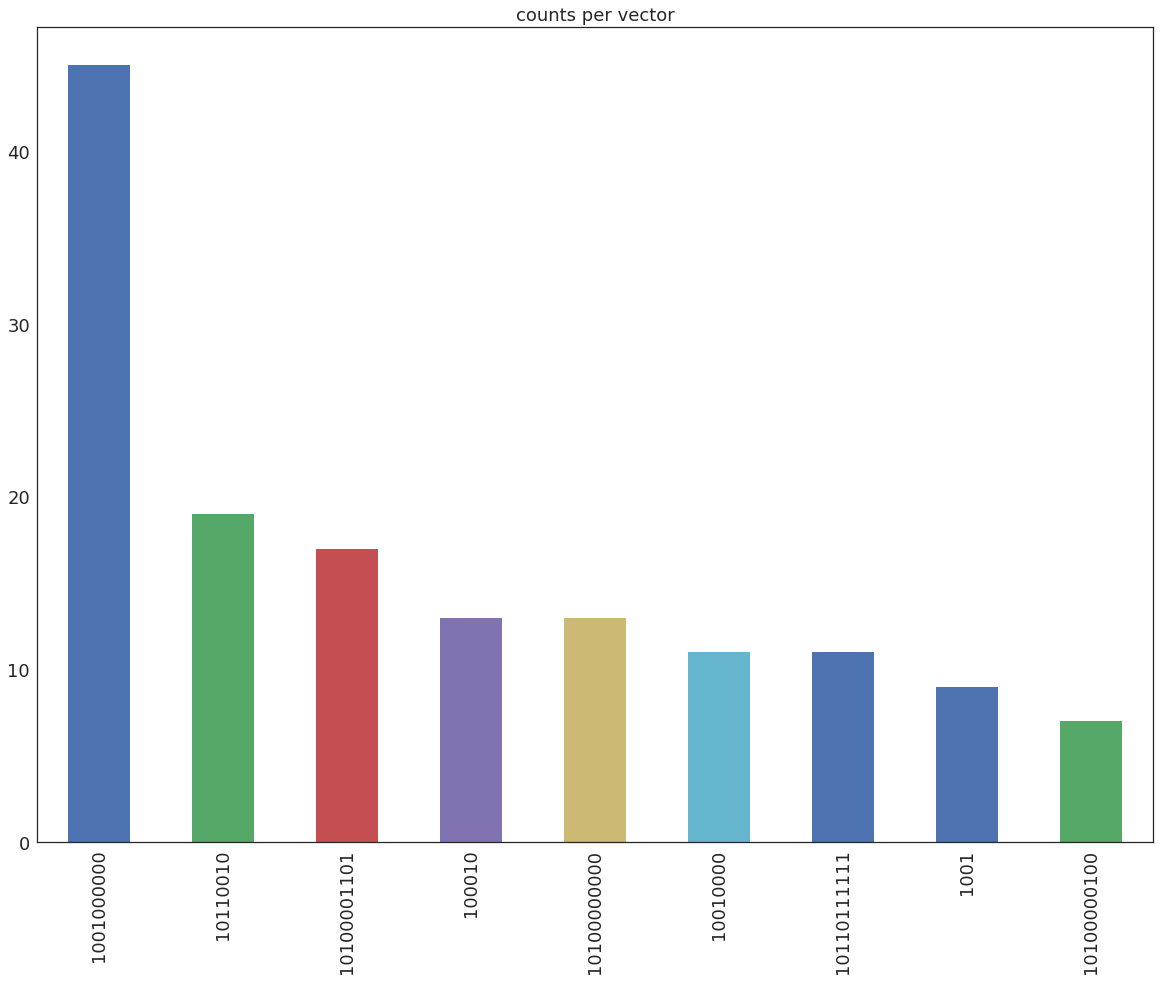

In [24]:
#Homozygote to homozygote
print "for Homozygote tree "
keep2=th
nmut2=keep2.vector.value_counts().reset_index(name="count").query("count >0")["index"]
nmut2=keep2[keep2.vector.isin(nmut2)]
nmut2=nmut2.vector.value_counts()

ax=nmut2.plot(kind="bar", title="counts per vector",figsize=(20, 15),fontsize=18)
print nmut2

for Homozygote leaf 
1             36
1000          35
100000        25
10            21
10000000      19
100           18
1000000000    16
1000000       10
100000000      8
10000          6
Name: vector, dtype: int64


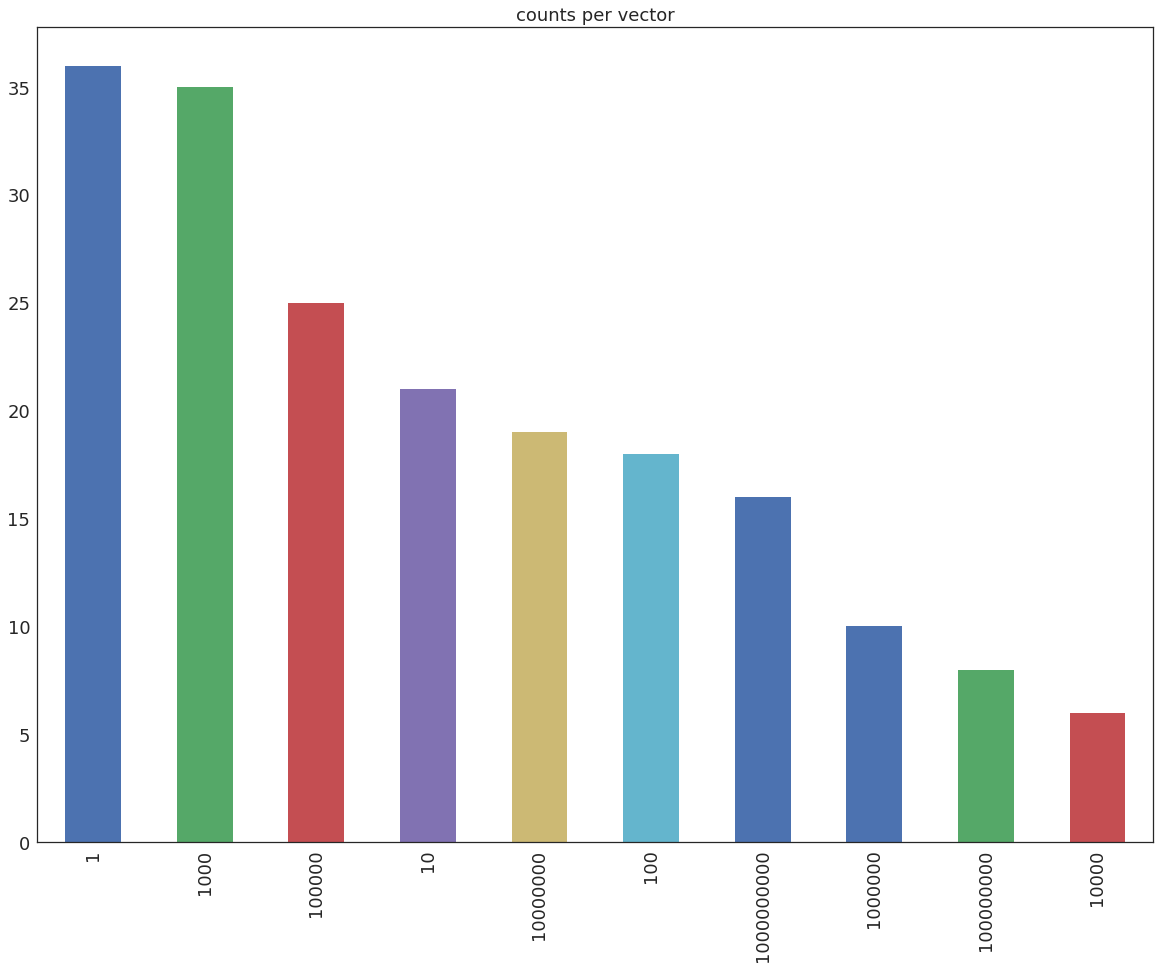

In [23]:
#Homozygote to homozygote
print "for Homozygote leaf "
keep2=lh
nmut2=keep2.vector.value_counts().reset_index(name="count").query("count >0")["index"]
nmut2=keep2[keep2.vector.isin(nmut2)]
nmut2=nmut2.vector.value_counts()

ax=nmut2.plot(kind="bar", title="counts per vector",figsize=(20, 15),fontsize=18)
print nmut2

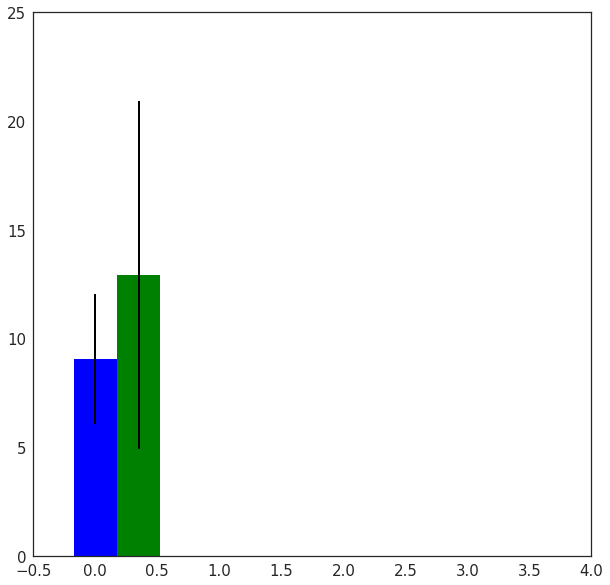

In [25]:
plt.figure(figsize=(40,5))
fig, ax = plt.subplots(figsize=(10, 10))
width = 0.35 
#Tree = 9.0625 +/- 3
#Leafs = 12.933 +/- 8
plt.ylim([0,25])
plt.xlim([-0.5,4])
rects1 = ax.bar(0,9.0625,width,color='blue',yerr=3,error_kw=dict(elinewidth=2,ecolor='black'))
rects1 = ax.bar(0+width,12.933,width,color='green',yerr=8,error_kw=dict(elinewidth=2,ecolor='black'))

# Mutation Signatures -> Figure 3b:

In [26]:
# This function plot the mutational signature
import itertools
import matplotlib.pyplot as plt


#run on all C->A (=G->T) and build the array of 16 options:
#A_A,A_C,A_G,A_T,C_A , .... = 16 options
def complete(base):
    if base=='A':
        res='T'
    elif base=='C':
        res='G'
    elif base=='G':
        res='C'
    elif base=='T':
        res='A'
    else:
        res='x'
    return res

def conv(mut,ind):#convert the context and the ref_all & alt all
    cont=mut.context[ind]
    ncont=[]
    #for base in cont:
    for base in reversed(cont):
        ncont.append(complete(base))
    ncont=''.join(map(str,ncont))
    #print ncont
    mut.set_value(index=ind,col='context',value=ncont)
    ref=complete(mut.ref_all[ind])
    mut.set_value(index=ind,col='ref_all',value=ref)
    alt=complete(mut.alt_all[ind])
    mut.set_value(index=ind,col='alt_all',value=alt)
    return mut

def draw_2dsign(keep):
    plt.figure(figsize=(40,10))     
    ax = plt.subplot(111)
    rkeep=keep #keep the original
    fs=26
    bar_width  = 1.0

    for i in rkeep.index:
        # convert all the oposite mutations for exmp G->T int C->A
        if ((rkeep.ref_all[i]=='G' and rkeep.alt_all[i]=='T') or
            (rkeep.ref_all[i]=='G' and rkeep.alt_all[i]=='C') or
            (rkeep.ref_all[i]=='G' and rkeep.alt_all[i]=='A') or
            (rkeep.ref_all[i]=='A' and rkeep.alt_all[i]=='T') or
            (rkeep.ref_all[i]=='A' and rkeep.alt_all[i]=='G') or
            (rkeep.ref_all[i]=='A' and rkeep.alt_all[i]=='C')):
                conv(rkeep,i)

    all=rkeep.shape[0]
    nuc=['A','C','G','T']
    constant='_'
    names=[]
    for k in range (6):
        for i in range(4):
            for j in range(4):
                temp=''.join(map(str,[nuc[i],constant,nuc[j]]))
                names.append(temp)
    x = np.array(range(len(names)))
    #print names
    signature=[]
    color=['cyan','black','red','grey','green','pink']
    itr=1
    full=[]
    for ref,alt in zip(['C','C','C','T','T','T'],['A','G','T','A','C','G']):
        X2X=np.zeros(16)
        temp=''.join(map(str,[ref,'->',alt]))
        signature.append(temp)
        for i in rkeep.index:
            #counting the signatures from couples which are true for both strands
            if (rkeep.ref_all[i]==ref and rkeep.alt_all[i]==alt):
                cc=0
                for j1 in range(4):
                    for j2 in range(4):
                        if (rkeep.context[i][2]==nuc[j1] and rkeep.context[i][4]==nuc[j2]):
                            X2X[cc]=X2X[cc]+1
                        cc=cc+1
        X2X=X2X/all
        full.append(X2X)
        itr=itr+1
    #print type(full)
    full = list(itertools.chain(*full))
    #print len(x)
    #print len(full)
    ax.set_ylabel("%")

    #ax.set_title("Mutation Signature")
    bars = ax.bar(x, full, alpha=0.8,)

    ax.set_yticks

    ax.set_xticks(x)
    ax.set_xticklabels(names,rotation=270,fontsize=fs)

  
    ncolor=[]
    index=-1
    cc=0
    for i in range(len(names)):
            if (i%16 ==0):
                index+=1
            ncolor.append(color[index])
            cc+=1        
        
    nncolor=ncolor        
    for xtick, ncolor in zip(ax.get_xticklabels(), ncolor):
        xtick.set_color(ncolor)

    cc=0
    for bar in bars:
        bar.set_facecolor(nncolor[cc])
        cc+=1

    ax.set_ylim([0,0.2])
    ax.yaxis.grid()
    plt.show()
    
    
    return 1

Tree signature:


/broad/blainey_lab/blainey-ipython/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:28: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/broad/blainey_lab/blainey-ipython/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:30: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/broad/blainey_lab/blainey-ipython/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:32: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


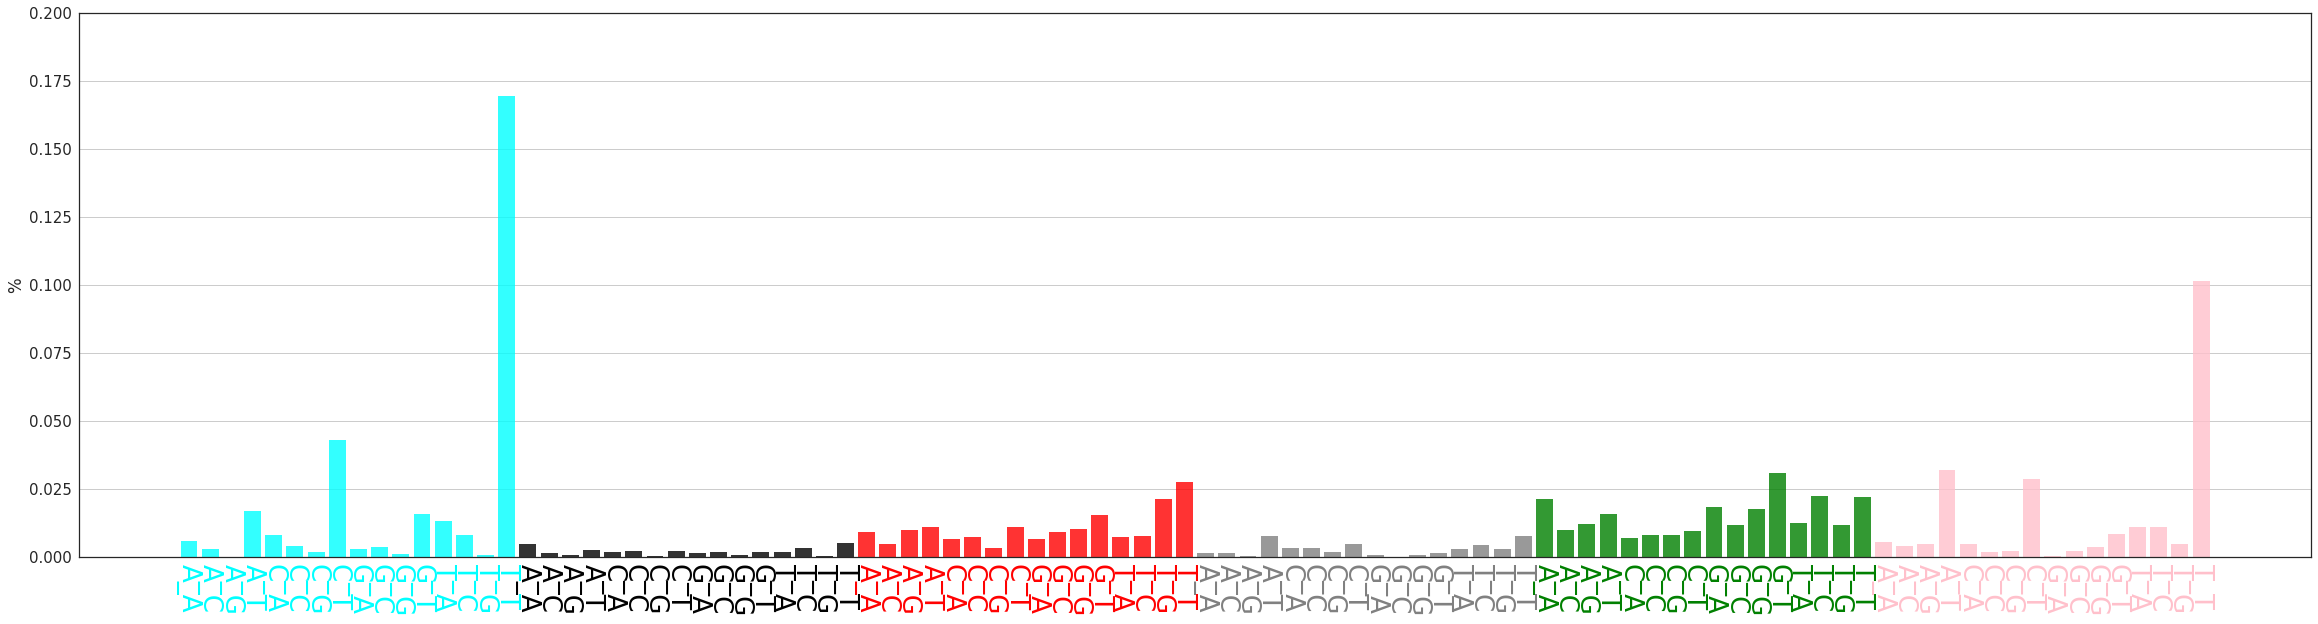

Leaf signature:


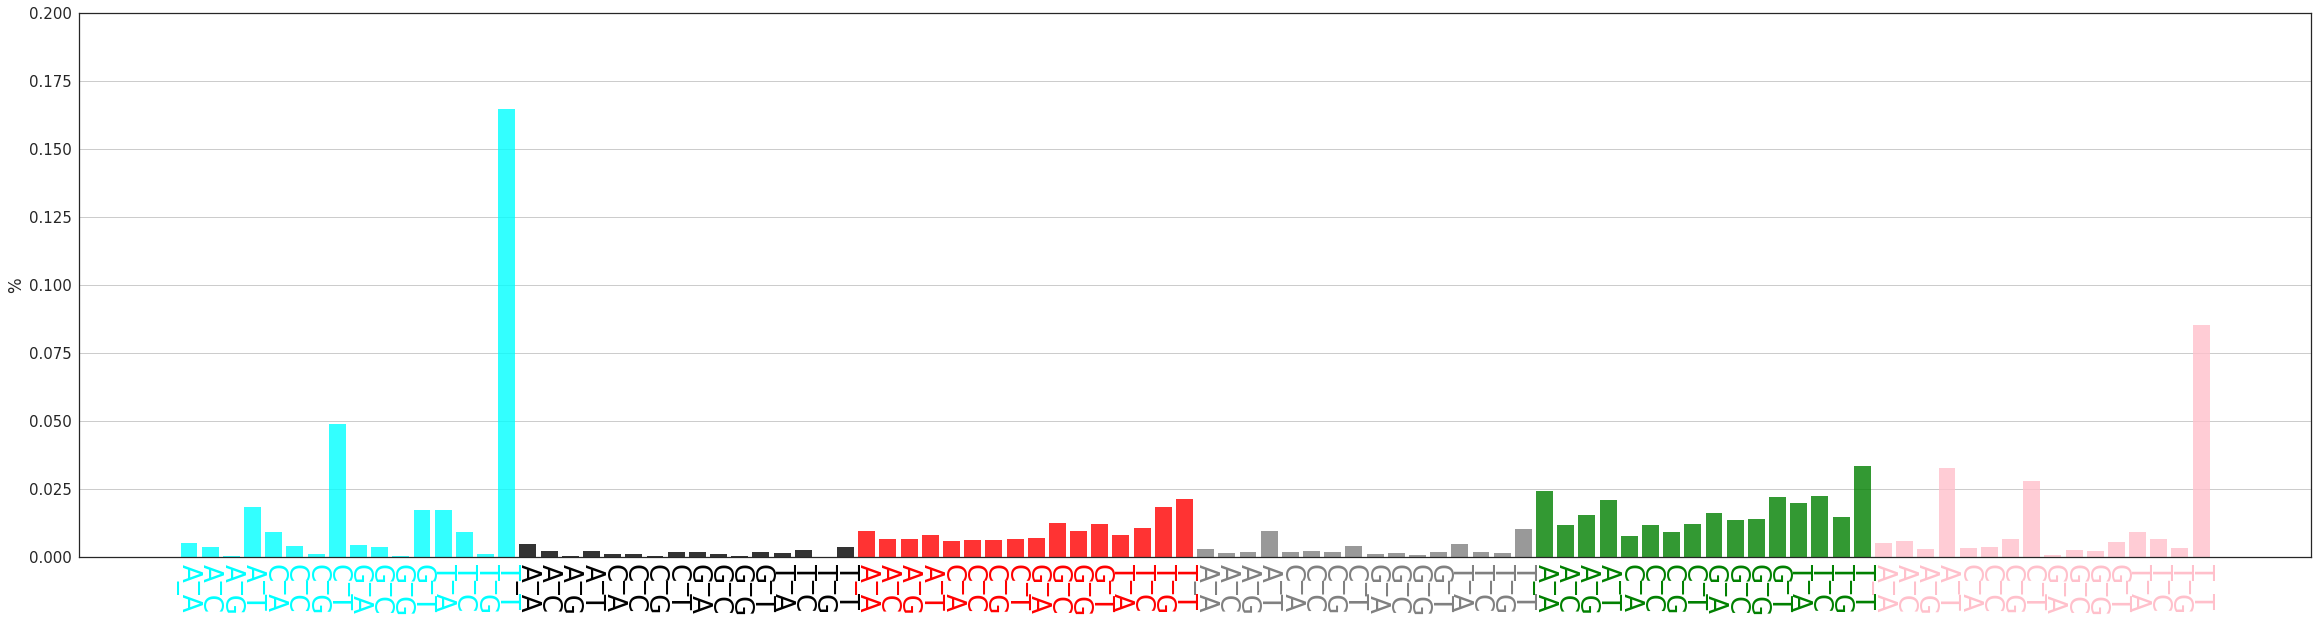

total_mutations:


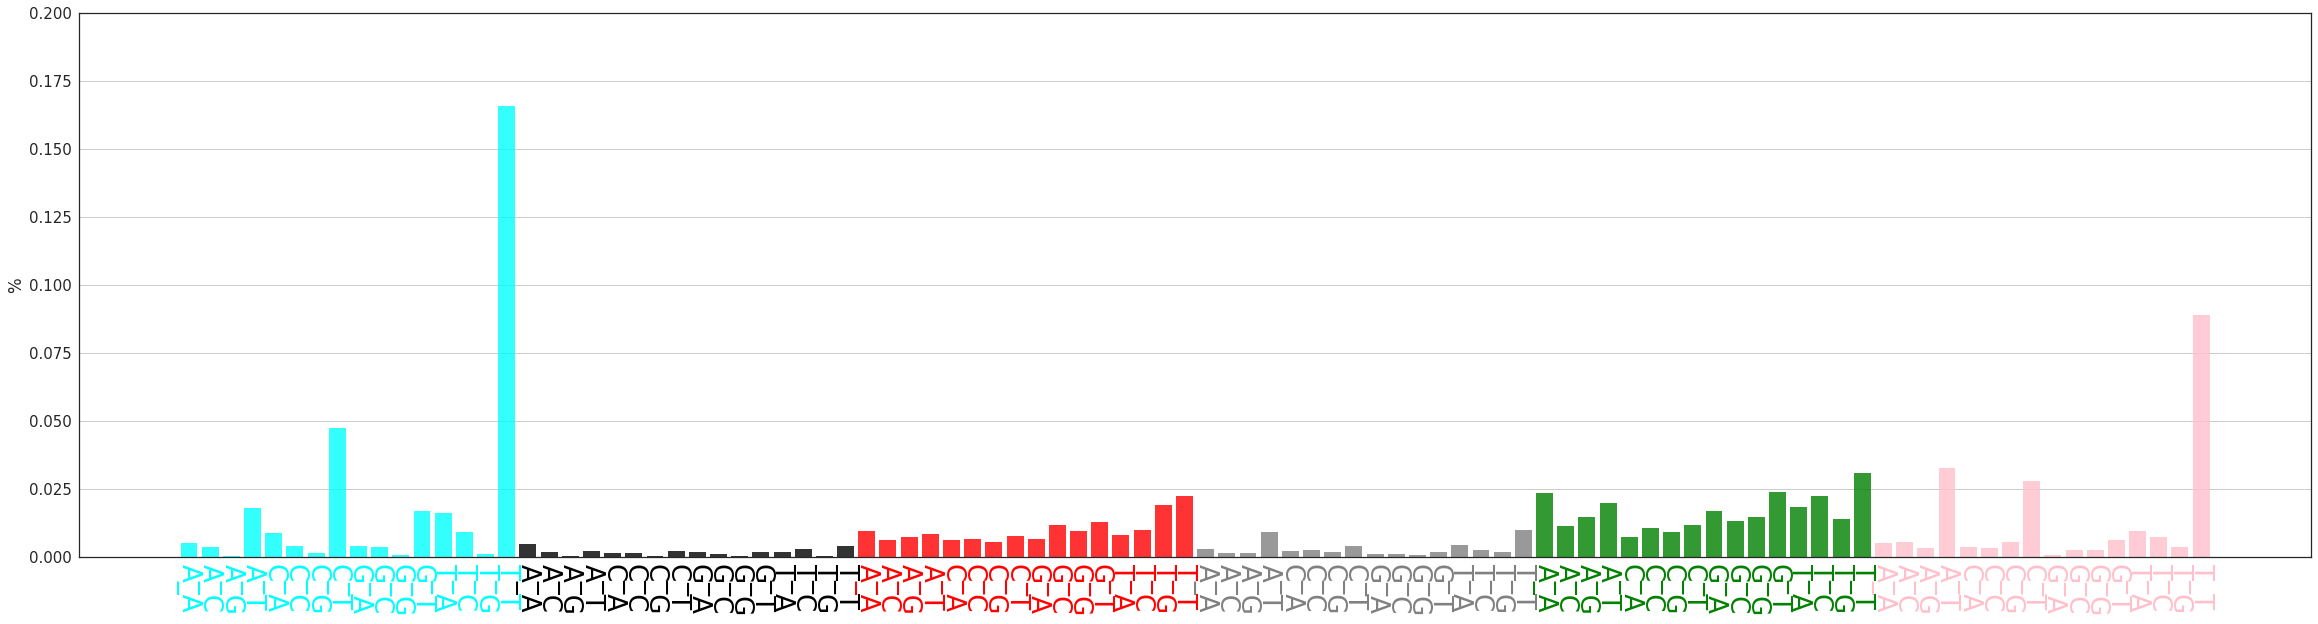

1

In [27]:
print "Tree signature:"
draw_2dsign(ttree)

print "Leaf signature:"
draw_2dsign(tleaf)

print "total_mutations:"
bigdata = pd.concat([ttree, tleaf], ignore_index=True)
draw_2dsign(bigdata)